In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
import warnings

warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("./loan_data_updated.csv")
df.head()

,loan_id,applicant_gender,applicant_married,applicant_dependents,applicant_education,applicant_employment,applicant_income,applicant_employment_history,applicant_credit_score,applicant_credit_default,...,co_applicant,co_applicant_income,co_applicant_employment,co_applicant_employment_history,co_applicant_credit_score,co_applicant_credit_default,loan_amount,loan_amount_term,property_area,loan_status
0,LP001003,Male,True,1,Graduate,Salaried,54996,30,401,True,...,False,18096,Not Applicable,0,650,False,128000.0,360.0,Rural,False
1,LP001005,Male,True,0,Graduate,Self-Employed,36000,38,738,True,...,True,0,Salaried,19,657,False,66000.0,360.0,Urban,True
2,LP001006,Male,True,0,Not Graduate,Salaried,30996,57,826,False,...,True,28296,Salaried,27,803,False,120000.0,360.0,Urban,True
3,LP001008,Male,False,0,Graduate,Salaried,72000,9,720,True,...,False,0,Not Applicable,0,650,False,141000.0,360.0,Urban,True
4,LP001013,Male,True,0,Not Graduate,Salaried,27996,4,752,False,...,False,18192,Not Applicable,0,650,False,95000.0,360.0,Urban,True


* loan_id: Identifier for the loan (unique for each row).
* applicant_gender, applicant_married, applicant_dependents, applicant_education, applicant_employment: Demographic and employment information about the applicant.
* applicant_income, applicant_employment_history, applicant_credit_score, applicant_credit_default, applicant_credit_history: Financial and credit history details of the applicant.
* co_applicant, co_applicant_income, co_applicant_employment, co_applicant_employment_history, co_applicant_credit_score, co_applicant_credit_default: Similar details for a co-applicant, if any.
* loan_amount, loan_amount_term: Details about the requested loan.
* property_area: Location type of the property.
* loan_status: Target variable indicating if the loan was approved or not.

In [3]:
df.drop(["loan_id"], axis = 1, inplace= True)

### EDA Exploration

In [4]:
# General Statistics
df.describe()

,applicant_income,applicant_employment_history,applicant_credit_score,applicant_credit_history,co_applicant_income,co_applicant_employment_history,co_applicant_credit_score,loan_amount,loan_amount_term
count,381.000000,381.000000,381.000000,381.000000,381.000000,381.000000,381.000000,381.00000,370.000000
mean,42958.141732,36.377953,697.454068,48.291339,15327.275591,11.388451,671.293963,104986.87664,340.864865
std,17037.765819,16.487601,150.826185,12.243437,28089.822557,15.443659,87.186779,28358.46362,68.549257
min,1800.000000,0.000000,302.000000,2.000000,0.000000,0.000000,401.000000,9000.00000,12.000000
25%,31200.000000,24.000000,627.000000,43.000000,0.000000,0.000000,650.000000,90000.00000,360.000000
50%,39996.000000,39.000000,734.000000,52.000000,11796.000000,0.000000,650.000000,110000.00000,360.000000
75%,51456.000000,51.000000,811.000000,58.000000,24192.000000,23.000000,682.000000,127000.00000,360.000000
max,116436.000000,60.000000,899.000000,60.000000,406044.000000,48.000000,900.000000,150000.00000,480.000000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381 entries, 0 to 380
Data columns (total 20 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   applicant_gender                 376 non-null    object 
 1   applicant_married                381 non-null    bool   
 2   applicant_dependents             373 non-null    object 
 3   applicant_education              381 non-null    object 
 4   applicant_employment             381 non-null    object 
 5   applicant_income                 381 non-null    int64  
 6   applicant_employment_history     381 non-null    int64  
 7   applicant_credit_score           381 non-null    int64  
 8   applicant_credit_default         381 non-null    bool   
 9   applicant_credit_history         381 non-null    int64  
 10  co_applicant                     381 non-null    bool   
 11  co_applicant_income              381 non-null    int64  
 12  co_applicant_employmen

In [6]:
categorical_features = [
    'applicant_gender', 'applicant_married', 'applicant_dependents',
    'applicant_education', 'applicant_employment', 'applicant_credit_default',
    'co_applicant', 'co_applicant_employment', 'co_applicant_credit_default',
    'property_area', 'loan_status'
]

numerical_features = [
    'applicant_income', 'applicant_employment_history', 'applicant_credit_score',
    'applicant_credit_history', 'co_applicant_income', 'co_applicant_employment_history',
    'co_applicant_credit_score', 'loan_amount', 'loan_amount_term'
]

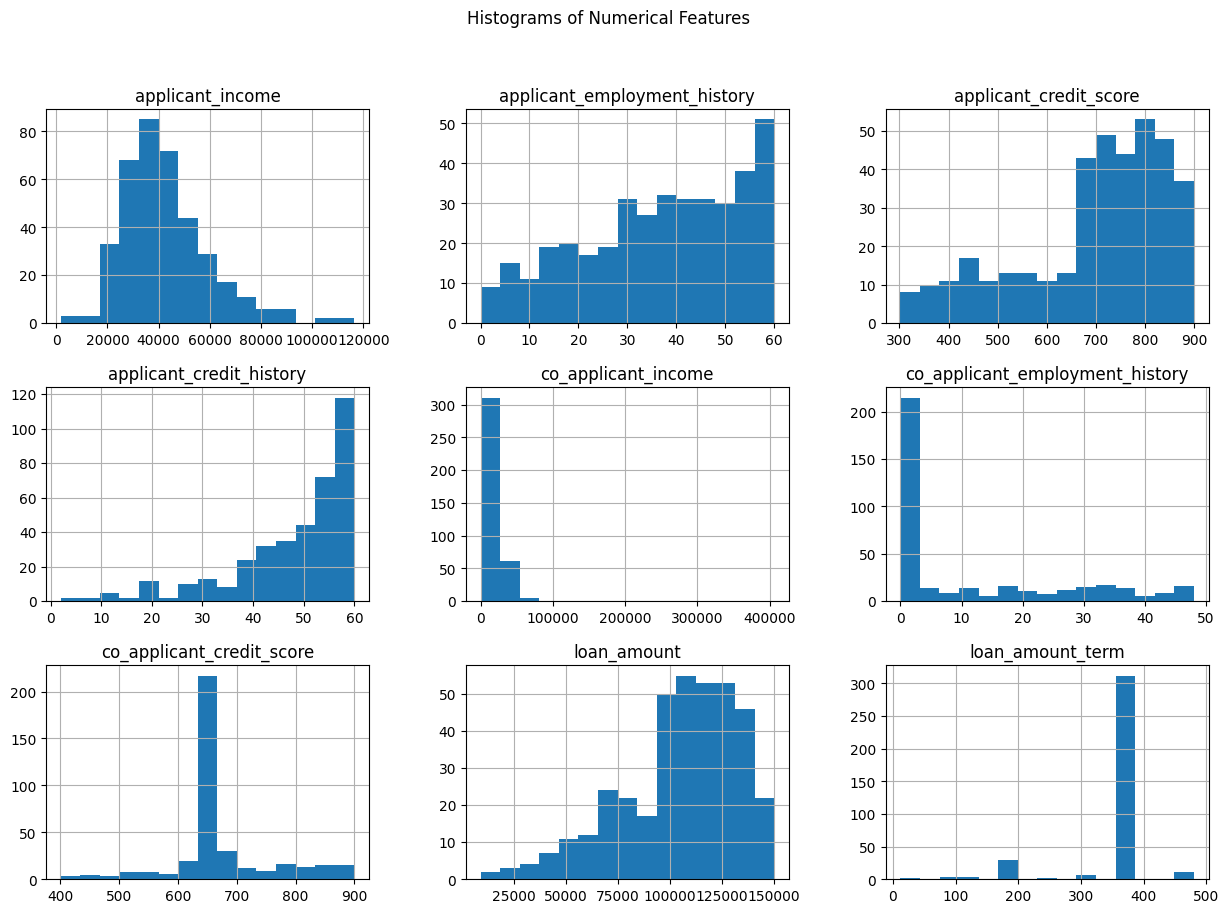

In [7]:
# Histograms for numerical features
df[numerical_features].hist(bins=15, figsize=(15, 10))
plt.suptitle('Histograms of Numerical Features')
plt.show()

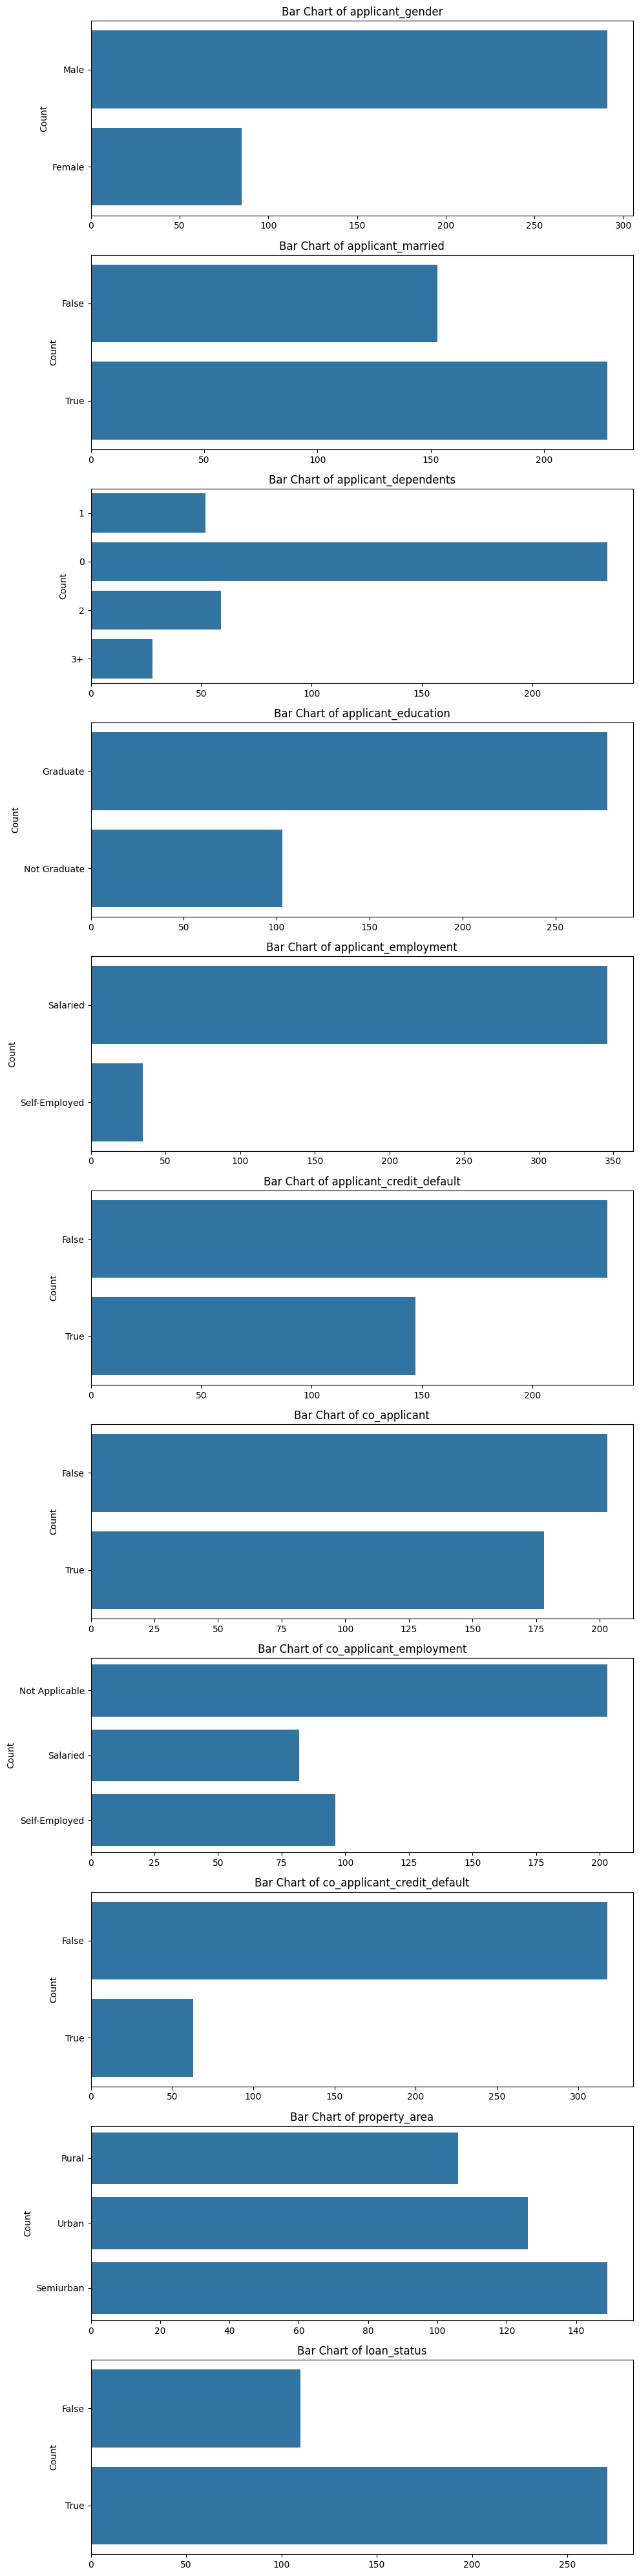

In [8]:
# Bar charts for categorical features
fig, axes = plt.subplots(nrows=len(categorical_features), ncols=1, figsize=(10, 40))
for i, col in enumerate(categorical_features):
    sns.countplot(y=col, data=df, ax=axes[i])
    axes[i].set_title(f'Bar Chart of {col}')
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Count')
plt.tight_layout()
plt.show()

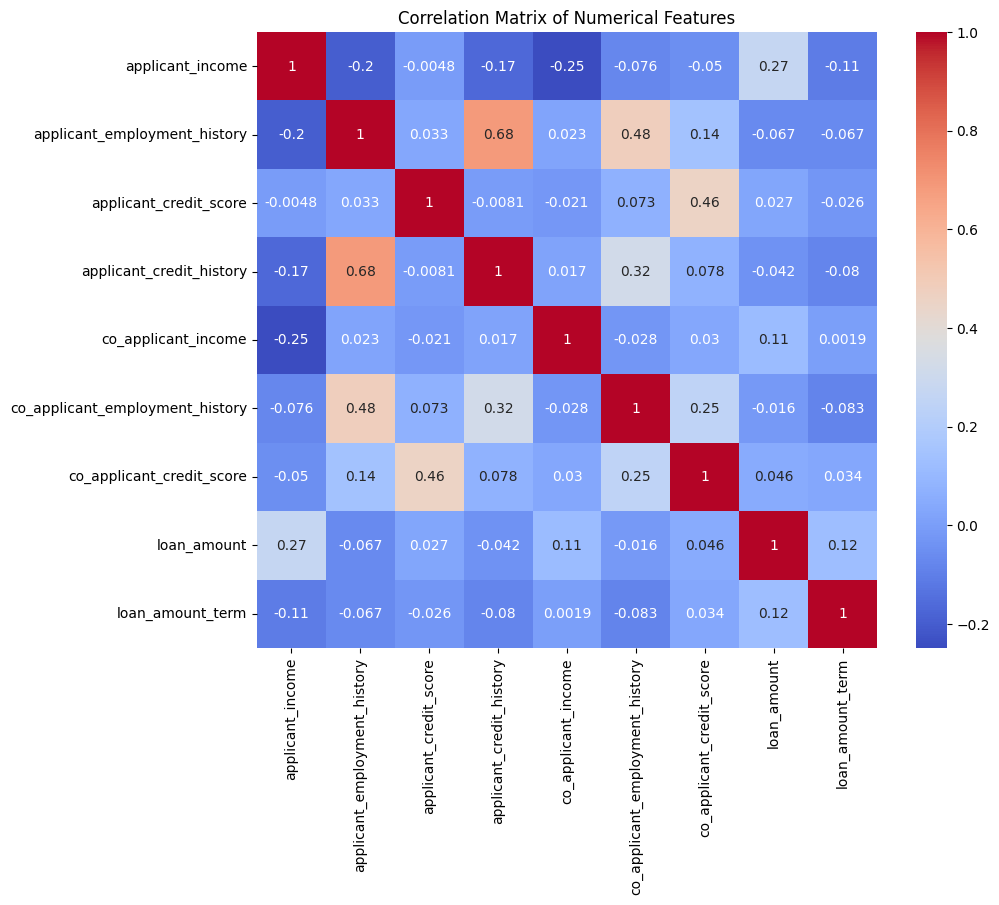

In [9]:
# Correlation matrix
corr_matrix = df[numerical_features].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Numerical Features')
plt.show()

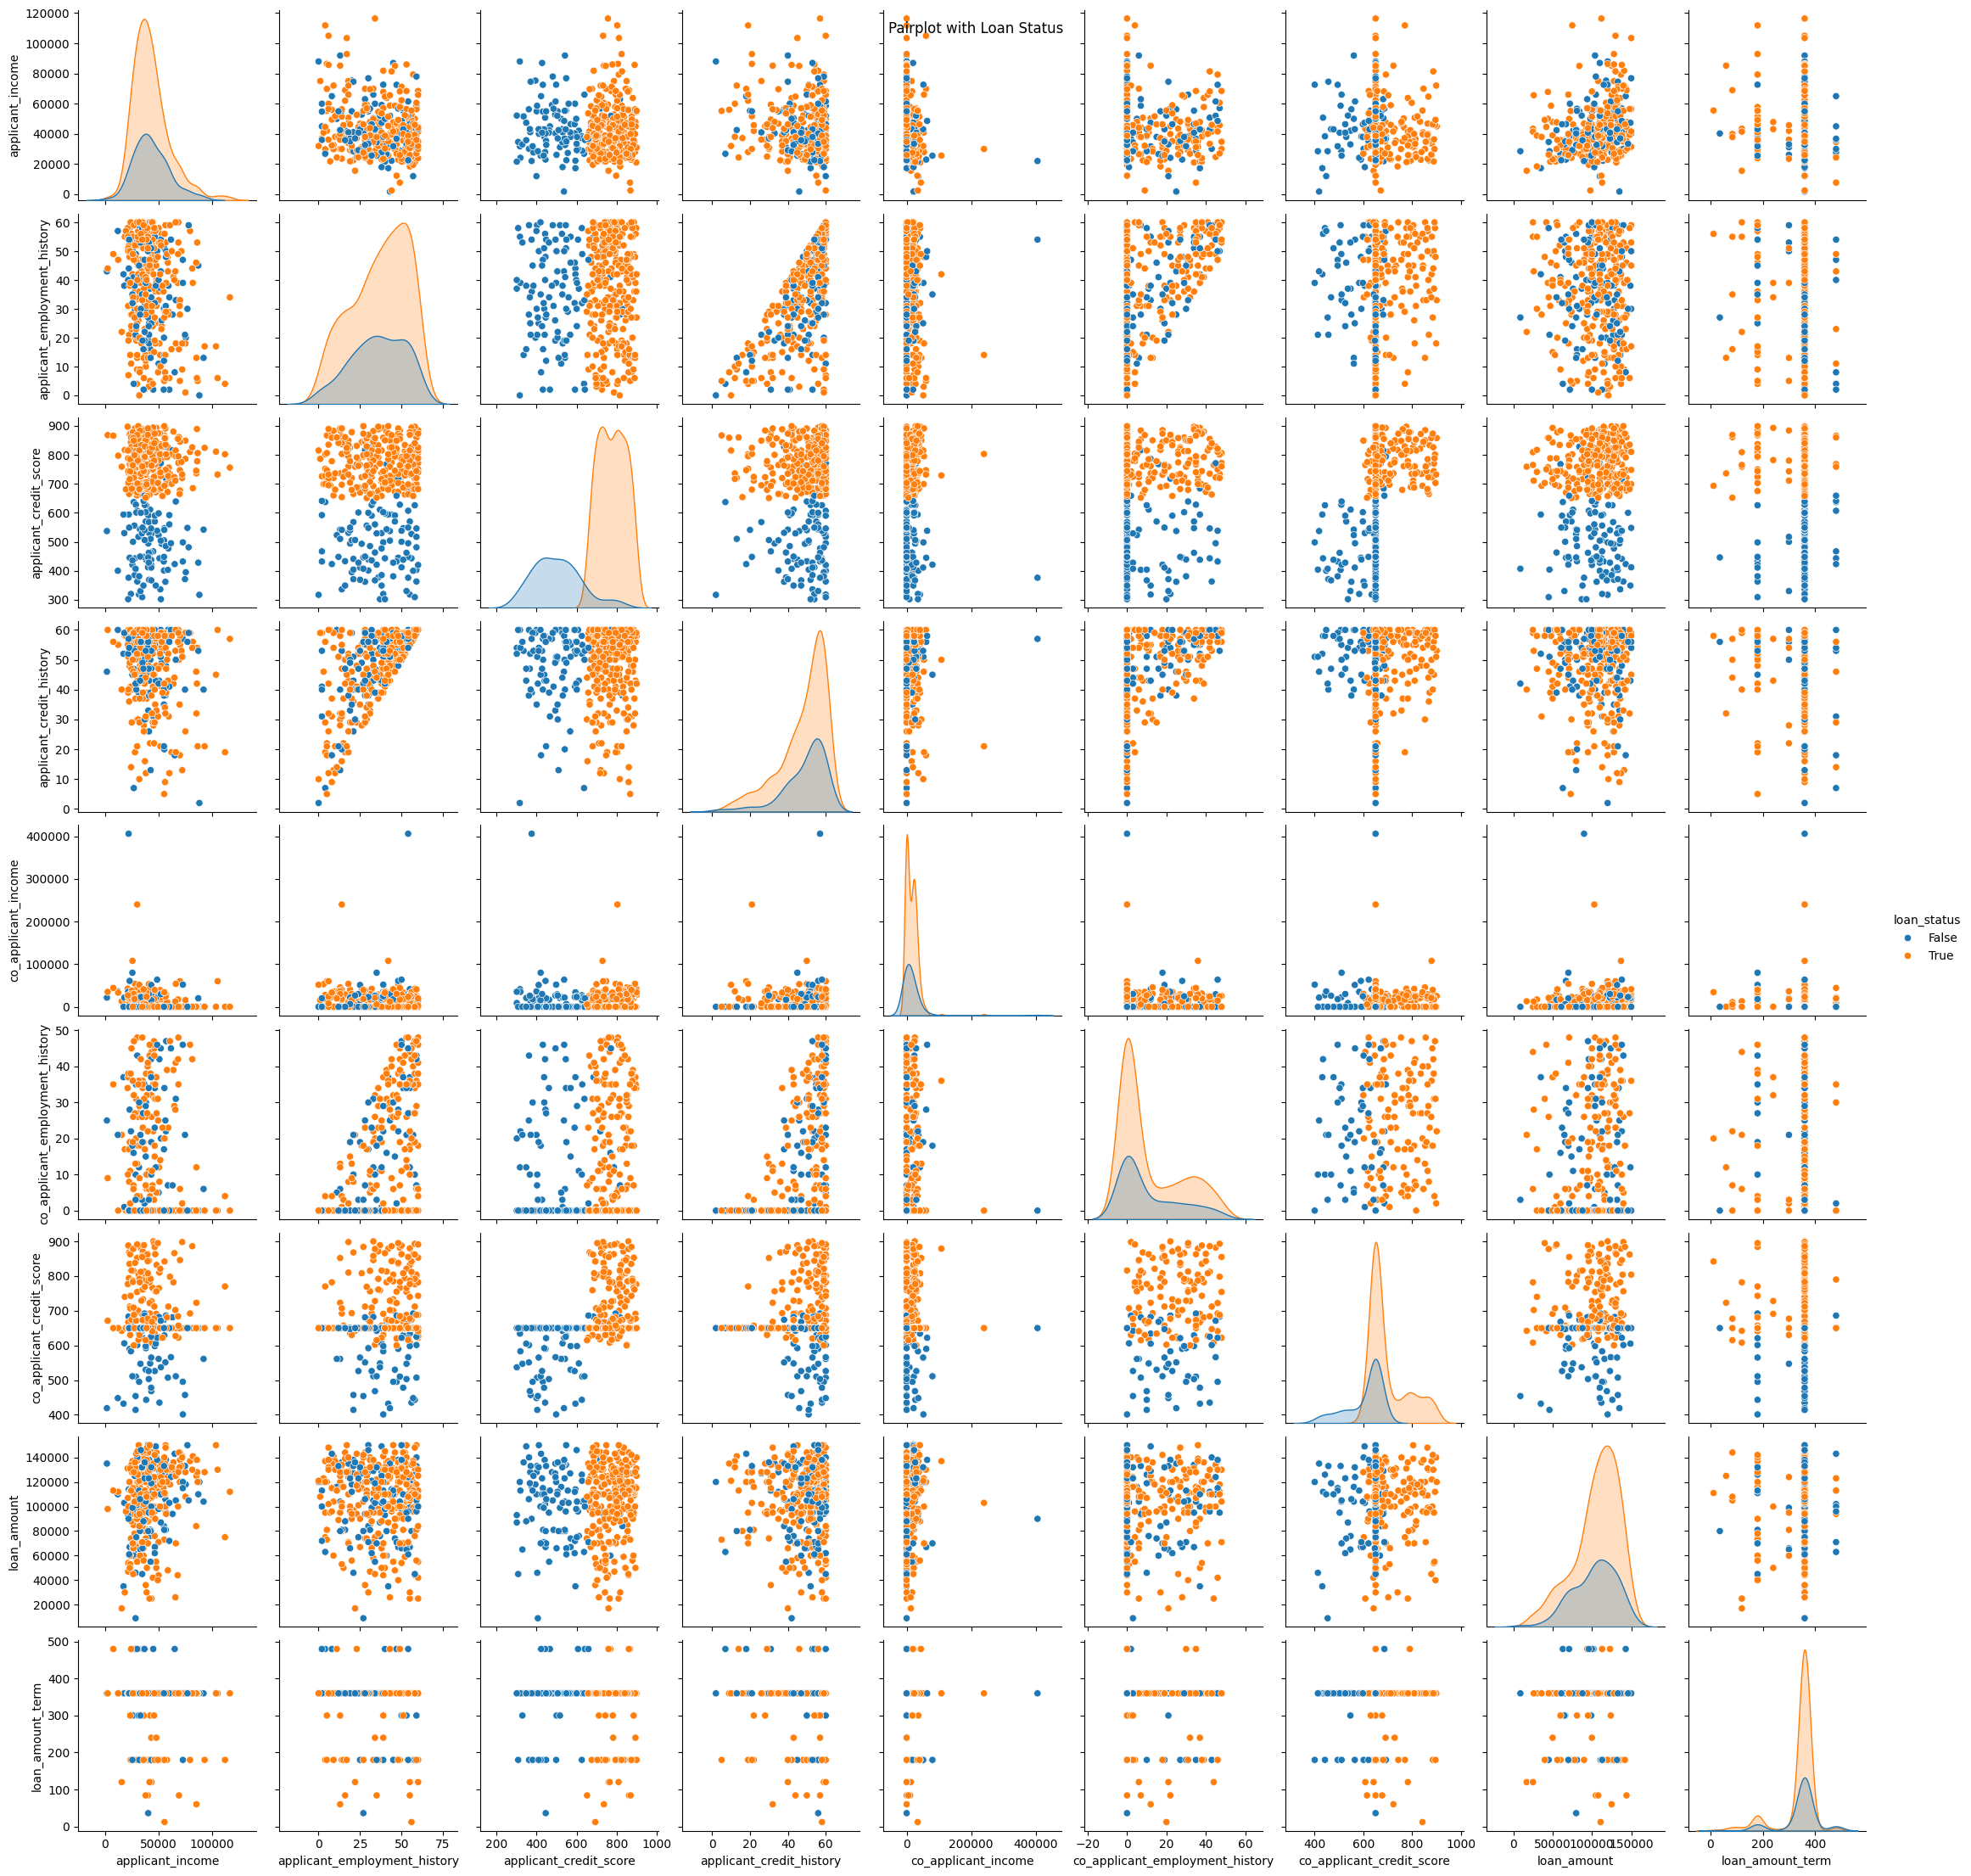

In [10]:
# Pairplot for selected features against the loan status
sns.pairplot(df, vars=numerical_features, hue='loan_status')
plt.suptitle('Pairplot with Loan Status')
plt.show()

In [11]:
df['loan_status'].value_counts()

loan_status
True     271
False    110
Name: count, dtype: int64

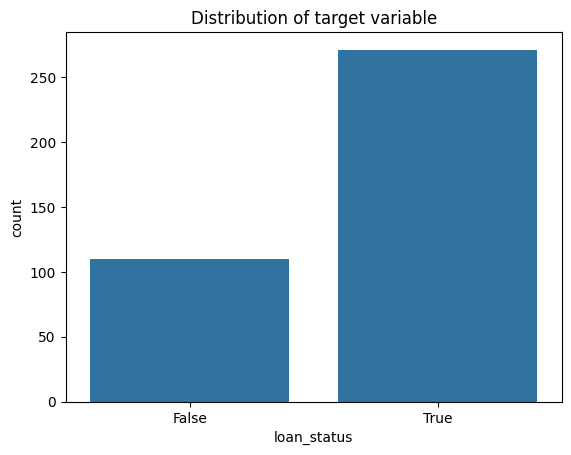

In [12]:
sns.countplot(data = df, x='loan_status')
plt.title("Distribution of target variable")
plt.show()

### Data Preprocessing

In [13]:
# Checking for missing values
print("Missing values per column:")
df.isnull().sum()

Missing values per column:


applicant_gender                    5
applicant_married                   0
applicant_dependents                8
applicant_education                 0
applicant_employment                0
applicant_income                    0
applicant_employment_history        0
applicant_credit_score              0
applicant_credit_default            0
applicant_credit_history            0
co_applicant                        0
co_applicant_income                 0
co_applicant_employment             0
co_applicant_employment_history     0
co_applicant_credit_score           0
co_applicant_credit_default         0
loan_amount                         0
loan_amount_term                   11
property_area                       0
loan_status                         0
dtype: int64

In [14]:
df = df.drop_duplicates().reset_index(drop=True)

In [15]:
df.dropna(inplace=True)

In [16]:
df.columns

Index(['applicant_gender', 'applicant_married', 'applicant_dependents',
       'applicant_education', 'applicant_employment', 'applicant_income',
       'applicant_employment_history', 'applicant_credit_score',
       'applicant_credit_default', 'applicant_credit_history', 'co_applicant',
       'co_applicant_income', 'co_applicant_employment',
       'co_applicant_employment_history', 'co_applicant_credit_score',
       'co_applicant_credit_default', 'loan_amount', 'loan_amount_term',
       'property_area', 'loan_status'],
      dtype='object')

In [17]:
df.head(n=10)

,applicant_gender,applicant_married,applicant_dependents,applicant_education,applicant_employment,applicant_income,applicant_employment_history,applicant_credit_score,applicant_credit_default,applicant_credit_history,co_applicant,co_applicant_income,co_applicant_employment,co_applicant_employment_history,co_applicant_credit_score,co_applicant_credit_default,loan_amount,loan_amount_term,property_area,loan_status
0,Male,True,1,Graduate,Salaried,54996,30,401,True,35,False,18096,Not Applicable,0,650,False,128000.0,360.0,Rural,False
1,Male,True,0,Graduate,Self-Employed,36000,38,738,True,53,True,0,Salaried,19,657,False,66000.0,360.0,Urban,True
2,Male,True,0,Not Graduate,Salaried,30996,57,826,False,60,True,28296,Salaried,27,803,False,120000.0,360.0,Urban,True
3,Male,False,0,Graduate,Salaried,72000,9,720,True,13,False,0,Not Applicable,0,650,False,141000.0,360.0,Urban,True
4,Male,True,0,Not Graduate,Salaried,27996,4,752,False,19,False,18192,Not Applicable,0,650,False,95000.0,360.0,Urban,True
5,Male,True,2,Graduate,Salaried,38400,32,723,False,44,True,8400,Self-Employed,6,692,True,70000.0,360.0,Urban,True
6,Male,True,2,Graduate,Salaried,30000,60,885,False,60,True,22080,Self-Employed,18,853,True,109000.0,360.0,Urban,True
7,Male,False,0,Graduate,Salaried,22236,44,594,True,56,False,34080,Not Applicable,0,650,False,114000.0,360.0,Rural,False
8,Male,True,2,Graduate,Salaried,15588,22,759,False,40,True,13032,Self-Employed,21,642,True,17000.0,120.0,Urban,True
9,Male,False,0,Graduate,Salaried,59400,29,756,False,31,False,0,Not Applicable,0,650,False,125000.0,360.0,Urban,True


In [18]:
df.applicant_gender = df.applicant_gender.apply(lambda x: 1 if str(x).lower() == "male" else 0)
df.applicant_education = df.applicant_education.apply(lambda x: 1 if str(x).lower() == "graduate" else 0)
df.applicant_employment = df.applicant_employment.apply(lambda x: 1 if str(x).lower() == "Salaried" else 0)
df.co_applicant_employment = df.co_applicant_employment.apply(lambda x: 1 if str(x).lower() == "Salaried" else 0)
df.applicant_credit_default = df.applicant_credit_default.apply(lambda x: 1 if x == False else 0)


In [19]:
cols_to_encode = ['applicant_dependents', "property_area"]
df = pd.get_dummies(df, columns=cols_to_encode, drop_first=True)
df.head()

,applicant_gender,applicant_married,applicant_education,applicant_employment,applicant_income,applicant_employment_history,applicant_credit_score,applicant_credit_default,applicant_credit_history,co_applicant,...,co_applicant_credit_score,co_applicant_credit_default,loan_amount,loan_amount_term,loan_status,applicant_dependents_1,applicant_dependents_2,applicant_dependents_3+,property_area_Semiurban,property_area_Urban
0,1,True,1,0,54996,30,401,0,35,False,...,650,False,128000.0,360.0,False,True,False,False,False,False
1,1,True,1,0,36000,38,738,0,53,True,...,657,False,66000.0,360.0,True,False,False,False,False,True
2,1,True,0,0,30996,57,826,1,60,True,...,803,False,120000.0,360.0,True,False,False,False,False,True
3,1,False,1,0,72000,9,720,0,13,False,...,650,False,141000.0,360.0,True,False,False,False,False,True
4,1,True,0,0,27996,4,752,1,19,False,...,650,False,95000.0,360.0,True,False,False,False,False,True


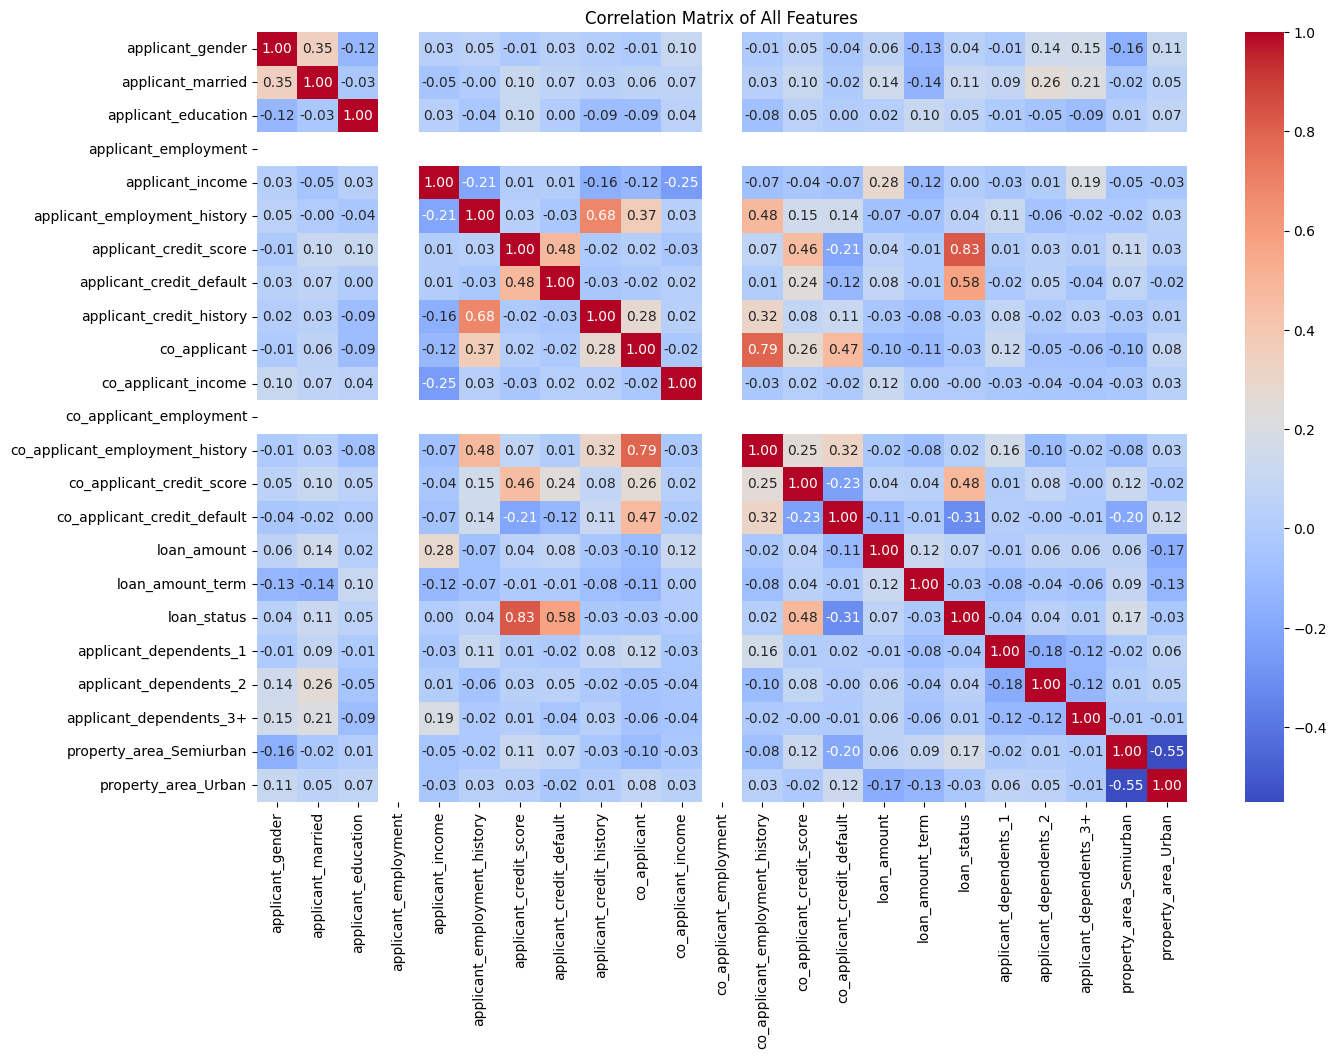

In [20]:
# Compute the correlation matrix
correlation_matrix = df.corr()

# Use seaborn to create a heatmap to visualize the correlation matrix
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix of All Features')
plt.show()

### Scenerio 1:

* Income should be greater than or equal to 2000.
* Credit Score should be greater than or equal to 650.
* Credit History should be greater than or equal to 30.
* Employment History should be greater than or equal to 18.
* Credit Default should be False.

In [21]:
#making a copy of the dataframe
df1 = df.copy()

In [22]:
# function for loan approval
def custom_loan_approval_1(row):
    if (row['applicant_income'] >= 2000 and
        row['applicant_credit_score'] >= 650 and
        row['applicant_credit_history'] >= 30 and
        row['applicant_employment_history'] >= 18 and
        not row['applicant_credit_default']):
        return True
    else:
        return False

def process_loan_application(row):
    if custom_loan_approval_1(row):
        return "Approved"
    else:
        return "Rejected"
        
# Apply the function to each row in the DataFrame
df1['custom_loan_status'] = df1.apply(process_loan_application, axis=1)

# Display the result
df1[
    ['applicant_income', 'applicant_credit_score', 'applicant_credit_history',  'applicant_employment_history', 'applicant_credit_default', 'custom_loan_status']
].sample(n=20)

,applicant_income,applicant_credit_score,applicant_credit_history,applicant_employment_history,applicant_credit_default,custom_loan_status
355,39996,687,51,51,1,Rejected
131,46200,722,59,49,0,Approved
117,50292,761,55,53,0,Approved
306,24996,683,29,28,1,Rejected
225,56676,485,41,31,0,Rejected
9,59400,756,31,29,1,Rejected
95,39048,843,37,15,1,Rejected
345,40296,446,56,27,0,Rejected
317,7740,866,56,49,1,Rejected
150,75000,786,59,1,1,Rejected


In [23]:
df1.custom_loan_status.value_counts()

custom_loan_status
Rejected    308
Approved     50
Name: count, dtype: int64

In [24]:
# Fature and target Variables
X = df1.drop(['loan_status', 'custom_loan_status'], axis=1)  
y = df1['custom_loan_status'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [25]:
# Normalization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [26]:
#Model Training
model = LogisticRegression()
model.fit(X_train_scaled, y_train)

LogisticRegression()

In [27]:
#Prediction
y_pred = model.predict(X_test_scaled)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9861111111111112
Classification Report:
               precision    recall  f1-score   support

    Approved       0.91      1.00      0.95        10
    Rejected       1.00      0.98      0.99        62

    accuracy                           0.99        72
   macro avg       0.95      0.99      0.97        72
weighted avg       0.99      0.99      0.99        72



In [28]:
importances = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': model.coef_[0]
})
importances = importances.sort_values(by='Importance', ascending=False)
print(importances)

                          Attribute  Importance
7          applicant_credit_default    3.570378
0                  applicant_gender    0.356391
15                      loan_amount    0.289628
19          applicant_dependents_3+    0.260974
2               applicant_education    0.250681
9                      co_applicant    0.196024
18           applicant_dependents_2    0.096668
4                  applicant_income    0.064797
20          property_area_Semiurban    0.055793
14      co_applicant_credit_default    0.051292
11          co_applicant_employment    0.000000
3              applicant_employment    0.000000
17           applicant_dependents_1   -0.006011
10              co_applicant_income   -0.021163
12  co_applicant_employment_history   -0.057097
16                 loan_amount_term   -0.213936
8          applicant_credit_history   -0.233185
21              property_area_Urban   -0.248863
1                 applicant_married   -0.257345
13        co_applicant_credit_score   -0

In [29]:
# Using a random forest for potentially better performance
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)
y_pred_rf = rf_model.predict(X_test_scaled)

print("RF Accuracy:", accuracy_score(y_test, y_pred_rf))
print("RF Classification Report:\n", classification_report(y_test, y_pred_rf))

RF Accuracy: 0.9722222222222222
RF Classification Report:
               precision    recall  f1-score   support

    Approved       1.00      0.80      0.89        10
    Rejected       0.97      1.00      0.98        62

    accuracy                           0.97        72
   macro avg       0.98      0.90      0.94        72
weighted avg       0.97      0.97      0.97        72



### Scenerio 2:


In [30]:
#making a copy of the dataframe
df2 = df.copy()
df2

,applicant_gender,applicant_married,applicant_education,applicant_employment,applicant_income,applicant_employment_history,applicant_credit_score,applicant_credit_default,applicant_credit_history,co_applicant,...,co_applicant_credit_score,co_applicant_credit_default,loan_amount,loan_amount_term,loan_status,applicant_dependents_1,applicant_dependents_2,applicant_dependents_3+,property_area_Semiurban,property_area_Urban
0,1,True,1,0,54996,30,401,0,35,False,...,650,False,128000.0,360.0,False,True,False,False,False,False
1,1,True,1,0,36000,38,738,0,53,True,...,657,False,66000.0,360.0,True,False,False,False,False,True
2,1,True,0,0,30996,57,826,1,60,True,...,803,False,120000.0,360.0,True,False,False,False,False,True
3,1,False,1,0,72000,9,720,0,13,False,...,650,False,141000.0,360.0,True,False,False,False,False,True
4,1,True,0,0,27996,4,752,1,19,False,...,650,False,95000.0,360.0,True,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
376,1,True,1,0,68436,53,795,1,59,True,...,657,True,128000.0,360.0,True,False,False,True,False,True
377,1,True,1,0,38784,54,698,0,58,False,...,650,False,108000.0,360.0,True,False,False,False,False,False
378,0,False,1,0,34800,54,760,1,59,True,...,855,False,71000.0,360.0,True,False,False,False,False,False
379,1,True,1,0,49272,48,703,1,58,True,...,895,False,40000.0,180.0,True,False,False,True,False,False


In [31]:
def custom_loan_approval_2(row):
    # Criteria for approving the loan
    if row['applicant_credit_score'] < 650 or row['applicant_credit_history'] < 10:
        if row['co_applicant'] and row['co_applicant_credit_score'] >= 650 and not row['co_applicant_credit_default']: 
            return True
        else:
            return False
    else:
        return True

def process_loan_application(row):
    if custom_loan_approval_2(row):
        return "Approved"
    else:
        return "Rejected"

In [32]:
# Apply the function to the DataFrame
df2['custom_loan_status'] = df2.apply(process_loan_application, axis=1)

# Display the results
df2[['applicant_credit_score', 'applicant_credit_history', 'co_applicant', 
               'co_applicant_employment', 'co_applicant_credit_score', 
               'co_applicant_credit_default', 
               'custom_loan_status']].sample(10)

,applicant_credit_score,applicant_credit_history,co_applicant,co_applicant_employment,co_applicant_credit_score,co_applicant_credit_default,custom_loan_status
296,598,42,False,0,650,False,Rejected
347,560,56,False,0,650,False,Rejected
245,815,60,True,0,627,False,Approved
344,695,26,False,0,650,False,Approved
194,723,28,False,0,650,False,Approved
251,770,45,True,0,889,False,Approved
352,825,60,True,0,641,True,Approved
266,845,58,True,0,846,False,Approved
137,821,57,True,0,832,False,Approved
219,813,52,True,0,792,True,Approved


In [33]:
df2.custom_loan_status.value_counts()

custom_loan_status
Approved    266
Rejected     92
Name: count, dtype: int64

In [34]:
# Fature and target Variables
X = df2.drop(['loan_status', 'custom_loan_status'], axis=1)  
y = df2['custom_loan_status'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [35]:
# Normalization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [36]:
#Model Training
model = LogisticRegression()
model.fit(X_train_scaled, y_train)

LogisticRegression()

In [37]:
#Prediction
y_pred = model.predict(X_test_scaled)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9722222222222222
Classification Report:
               precision    recall  f1-score   support

    Approved       0.98      0.98      0.98        57
    Rejected       0.93      0.93      0.93        15

    accuracy                           0.97        72
   macro avg       0.96      0.96      0.96        72
weighted avg       0.97      0.97      0.97        72



In [38]:
importances = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': model.coef_[0]
})
importances = importances.sort_values(by='Importance', ascending=False)
print(importances)

                          Attribute  Importance
17           applicant_dependents_1    0.516697
14      co_applicant_credit_default    0.487590
2               applicant_education    0.328656
4                  applicant_income    0.193719
18           applicant_dependents_2    0.021107
1                 applicant_married    0.018013
11          co_applicant_employment    0.000000
3              applicant_employment    0.000000
12  co_applicant_employment_history   -0.053537
0                  applicant_gender   -0.063721
19          applicant_dependents_3+   -0.075134
15                      loan_amount   -0.093258
20          property_area_Semiurban   -0.112090
21              property_area_Urban   -0.135349
16                 loan_amount_term   -0.137936
10              co_applicant_income   -0.139802
5      applicant_employment_history   -0.230927
8          applicant_credit_history   -0.386875
9                      co_applicant   -0.466023
7          applicant_credit_default   -1

In [39]:
# Using a random forest for potentially better performance
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)
y_pred_rf = rf_model.predict(X_test_scaled)

print("RF Accuracy:", accuracy_score(y_test, y_pred_rf))
print("RF Classification Report:\n", classification_report(y_test, y_pred_rf))

RF Accuracy: 1.0
RF Classification Report:
               precision    recall  f1-score   support

    Approved       1.00      1.00      1.00        57
    Rejected       1.00      1.00      1.00        15

    accuracy                           1.00        72
   macro avg       1.00      1.00      1.00        72
weighted avg       1.00      1.00      1.00        72



# Scenerio 3:

In [40]:
df3 = df.copy()

In [41]:
def custom_loan_approval_3(row):
    if (row['applicant_income'] >= 2000 and
        row['applicant_credit_score'] >= 650 and
        row['applicant_credit_history'] >= 30 and
        row['applicant_employment_history'] >= 18 and
        not row['applicant_credit_default'] and
        (row['property_area_Semiurban'] == 1 or row['property_area_Urban'] == 1)):
        return True
    else:
        return False




def process_loan_application(row):
    if custom_loan_approval_3(row):
        return "Approved"
    else:
        return "Rejected"

In [42]:
# Apply the function to the DataFrame
df3['custom_loan_status'] = df3.apply(process_loan_application, axis=1)

# Display the results
df3[['applicant_credit_score', 'applicant_credit_history', 'co_applicant', 
               'co_applicant_employment', 'co_applicant_credit_score', 
               'co_applicant_credit_default', 
               'custom_loan_status']].sample(10)

,applicant_credit_score,applicant_credit_history,co_applicant,co_applicant_employment,co_applicant_credit_score,co_applicant_credit_default,custom_loan_status
194,723,28,False,0,650,False,Rejected
200,882,48,False,0,650,False,Rejected
59,720,37,True,0,693,True,Rejected
114,692,45,False,0,650,False,Rejected
313,869,57,True,0,677,False,Approved
36,721,56,False,0,650,False,Rejected
9,756,31,False,0,650,False,Rejected
335,802,52,False,0,650,False,Approved
170,699,59,True,0,804,False,Rejected
136,768,47,True,0,668,True,Approved


In [43]:
df3.custom_loan_status.value_counts()

custom_loan_status
Rejected    319
Approved     39
Name: count, dtype: int64

In [44]:
# Fature and target Variables
X = df3.drop(['loan_status', 'custom_loan_status'], axis=1)  
y = df3['custom_loan_status'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [45]:
# Normalization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [46]:
#Model Training
model = LogisticRegression()
model.fit(X_train_scaled, y_train)

LogisticRegression()

In [47]:
#Prediction
y_pred = model.predict(X_test_scaled)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9861111111111112
Classification Report:
               precision    recall  f1-score   support

    Approved       0.86      1.00      0.92         6
    Rejected       1.00      0.98      0.99        66

    accuracy                           0.99        72
   macro avg       0.93      0.99      0.96        72
weighted avg       0.99      0.99      0.99        72



In [48]:
importances = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': model.coef_[0]
})
importances = importances.sort_values(by='Importance', ascending=False)
print(importances)

                          Attribute  Importance
7          applicant_credit_default    3.144564
19          applicant_dependents_3+    0.432190
15                      loan_amount    0.364673
0                  applicant_gender    0.333310
9                      co_applicant    0.236403
14      co_applicant_credit_default    0.158345
10              co_applicant_income    0.072273
2               applicant_education    0.064649
4                  applicant_income    0.055212
17           applicant_dependents_1    0.036222
18           applicant_dependents_2    0.022893
11          co_applicant_employment    0.000000
3              applicant_employment    0.000000
16                 loan_amount_term   -0.122425
12  co_applicant_employment_history   -0.126173
1                 applicant_married   -0.324661
8          applicant_credit_history   -0.470845
13        co_applicant_credit_score   -0.546373
5      applicant_employment_history   -0.749971
20          property_area_Semiurban   -1

In [49]:
# Using a random forest for potentially better performance
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)
y_pred_rf = rf_model.predict(X_test_scaled)

print("RF Accuracy:", accuracy_score(y_test, y_pred_rf))
print("RF Classification Report:\n", classification_report(y_test, y_pred_rf))

RF Accuracy: 0.9305555555555556
RF Classification Report:
               precision    recall  f1-score   support

    Approved       0.67      0.33      0.44         6
    Rejected       0.94      0.98      0.96        66

    accuracy                           0.93        72
   macro avg       0.80      0.66      0.70        72
weighted avg       0.92      0.93      0.92        72



# Scenario 4

In [50]:
df4 = df.copy()

In [51]:
def custom_loan_approval_4(row):
    # Custom criteria for loan approval
    if row['applicant_income'] >= 3000 and row['loan_amount'] <= 80000:
        if row['applicant_credit_score'] >= 700 or row['applicant_credit_history'] >= 36:
            return True
        else:
            if row['co_applicant'] and row['co_applicant_credit_score'] >= 680 and not row['co_applicant_credit_default']:
                return True
            else:
                return False
    else:
        return False


def process_loan_application(row):
    if custom_loan_approval_4(row):
        return "Approved"
    else:
        return "Rejected"

In [52]:
# Apply the function to the DataFrame
df4['custom_loan_status'] = df4.apply(process_loan_application, axis=1)

# Display the results
df4[['applicant_credit_score', 'applicant_credit_history', 'co_applicant', 
               'co_applicant_employment', 'co_applicant_credit_score', 
               'co_applicant_credit_default', 
               'custom_loan_status']].sample(10)

,applicant_credit_score,applicant_credit_history,co_applicant,co_applicant_employment,co_applicant_credit_score,co_applicant_credit_default,custom_loan_status
265,766,54,True,0,664,False,Rejected
9,756,31,False,0,650,False,Rejected
2,826,60,True,0,803,False,Rejected
171,765,35,False,0,650,False,Rejected
194,723,28,False,0,650,False,Rejected
224,641,53,False,0,650,False,Rejected
89,796,52,False,0,650,False,Rejected
48,626,58,True,0,443,True,Rejected
92,672,50,False,0,650,False,Rejected
226,699,39,False,0,650,False,Rejected


In [53]:
df4.custom_loan_status.value_counts()

custom_loan_status
Rejected    291
Approved     67
Name: count, dtype: int64

In [54]:
# Fature and target Variables
X = df4.drop(['loan_status', 'custom_loan_status'], axis=1)  
y = df4['custom_loan_status'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [55]:
# Normalization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [56]:
#Model Training
model = LogisticRegression()
model.fit(X_train_scaled, y_train)

LogisticRegression()

In [57]:
#Prediction
y_pred = model.predict(X_test_scaled)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 1.0
Classification Report:
               precision    recall  f1-score   support

    Approved       1.00      1.00      1.00        14
    Rejected       1.00      1.00      1.00        58

    accuracy                           1.00        72
   macro avg       1.00      1.00      1.00        72
weighted avg       1.00      1.00      1.00        72



In [58]:
importances = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': model.coef_[0]
})
importances = importances.sort_values(by='Importance', ascending=False)
print(importances)

                          Attribute  Importance
15                      loan_amount    3.854688
16                 loan_amount_term    0.663903
10              co_applicant_income    0.622118
1                 applicant_married    0.550618
19          applicant_dependents_3+    0.473731
17           applicant_dependents_1    0.394777
4                  applicant_income    0.131093
20          property_area_Semiurban    0.128991
5      applicant_employment_history    0.125998
6            applicant_credit_score    0.117683
13        co_applicant_credit_score    0.084611
18           applicant_dependents_2    0.059403
11          co_applicant_employment    0.000000
3              applicant_employment    0.000000
7          applicant_credit_default   -0.066268
12  co_applicant_employment_history   -0.071941
2               applicant_education   -0.088549
14      co_applicant_credit_default   -0.171024
9                      co_applicant   -0.186302
0                  applicant_gender   -0

In [59]:
# Using a random forest for potentially better performance
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)
y_pred_rf = rf_model.predict(X_test_scaled)

print("RF Accuracy:", accuracy_score(y_test, y_pred_rf))
print("RF Classification Report:\n", classification_report(y_test, y_pred_rf))

RF Accuracy: 0.9861111111111112
RF Classification Report:
               precision    recall  f1-score   support

    Approved       1.00      0.93      0.96        14
    Rejected       0.98      1.00      0.99        58

    accuracy                           0.99        72
   macro avg       0.99      0.96      0.98        72
weighted avg       0.99      0.99      0.99        72

